# Benchmarking the lie detection classifiers against each other

In [1]:
import numpy as np
import torch

import pandas as pd

import os
from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'   # better inline figure resolution

# repository imports
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics, compute_average_accuracies
from probes import CCSProbe, TTPD, LRProbe, MMProbe

/tmp/ipykernel_24902/933925145.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# hyperparameters
model_family = 'Llama3' # options are 'Llama3', 'Llama2', 'Gemma', 'Gemma2' or 'Mistral'
model_size = '8B'
model_type = 'chat' # options are 'chat' or 'base'
layer = 12 # layer from which to extract activations
model_name = f"{model_family}_{model_size}_{model_type}"   # for saving the plots

device = 'cuda:1' if torch.cuda.is_available() else 'cpu' # gpu speeds up CCS training a fair bit but is not required
device


# define datasets used for training
train_sets = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors", "neg_inventors", "animal_class",
                  "neg_animal_class", "element_symb", "neg_element_symb", "facts", "neg_facts"]  # len = 12
# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets) 

In [3]:
def show_and_save_results (probe_accuracies, stats, file_name) :
    result_lines = []
    for probe_type, stats in probe_accuracies.items():
        result_lines.append(f"{probe_type}:")
        result_lines.append(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
        result_lines.append(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")
    result_str = "\n".join(result_lines)

    # Show the results.
    print(result_str)

    # Save the results to a .txt file in the results/ directory.
    os.makedirs("results", exist_ok=True)   # Ensure that the results/ directory exists.
    with open(f"./results/lie_detection--{file_name}--{model_name}.txt", "w") as f:
        f.write(result_str)

### Testing generalization to unseen topics

In [4]:
# compare TTPD, LR and CCS on topic-specific datasets
probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {
    TTPD: defaultdict(list), 
    LRProbe: defaultdict(list), 
    CCSProbe: defaultdict(list), 
    MMProbe: defaultdict(list)}
num_iter = 20   # number of times the probes are trained and evaluated on the same datasets

total_iterations = len(probe_types) * num_iter * len(train_sets)   # number_of_probes * number_of_iterations * number_of_datasets
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            indices = np.arange(0, 12, 2)   # indices of the datasets to be used for training
            for i in indices:
                cv_train_sets = np.delete(np.array(train_sets), [i, i+1], axis=0)
                # load training data
                acts_centered, acts, labels, polarities = collect_training_data(cv_train_sets, train_set_sizes, model_family, model_size, model_type, layer)
                
                # train classifier
                if probe_type == TTPD:
                    probe = TTPD.from_data(acts_centered, acts, labels, polarities)
                if probe_type == LRProbe:
                    probe = LRProbe.from_data(acts, labels)
                if probe_type == CCSProbe:
                    acts_affirm = acts[polarities == 1.0]
                    acts_neg = acts[polarities == -1.0]
                    labels_affirm = labels[polarities == 1.0]
                    mean_affirm = torch.mean(acts_affirm, dim=0) 
                    mean_neg = torch.mean(acts_neg, dim=0)
                    acts_affirm = acts_affirm - mean_affirm
                    acts_neg = acts_neg - mean_neg
                    probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
                if probe_type == MMProbe:
                    probe = MMProbe.from_data(acts, labels)

                # evaluate classification accuracy on held out datasets
                dm = DataManager()
                for j in range(0,2):
                    dm.add_dataset(train_sets[i+j], model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                    acts, labels = dm.data[train_sets[i+j]]
                    
                    # classifier specific predictions
                    if probe_type == CCSProbe:
                        if j == 0:
                            acts = acts - mean_affirm
                        if j == 1:
                            acts = acts - mean_neg
                    predictions = probe.pred(acts)
                    results[probe_type][train_sets[i+j]].append((predictions == labels).float().mean().item())
                    pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

Training and evaluating classifiers: 100%|██████████| 960/960 [09:24<00:00,  1.70it/s]


In [5]:
show_and_save_results(probe_accuracies, stat_results, "unseen_topics")

TTPD:
  Mean Accuracy: 94.03%
  Standard Deviation of the mean accuracy: 0.23%
LRProbe:
  Mean Accuracy: 95.00%
  Standard Deviation of the mean accuracy: 0.46%
CCSProbe:
  Mean Accuracy: 83.14%
  Standard Deviation of the mean accuracy: 7.94%
MMProbe:
  Mean Accuracy: 91.99%
  Standard Deviation of the mean accuracy: 0.41%


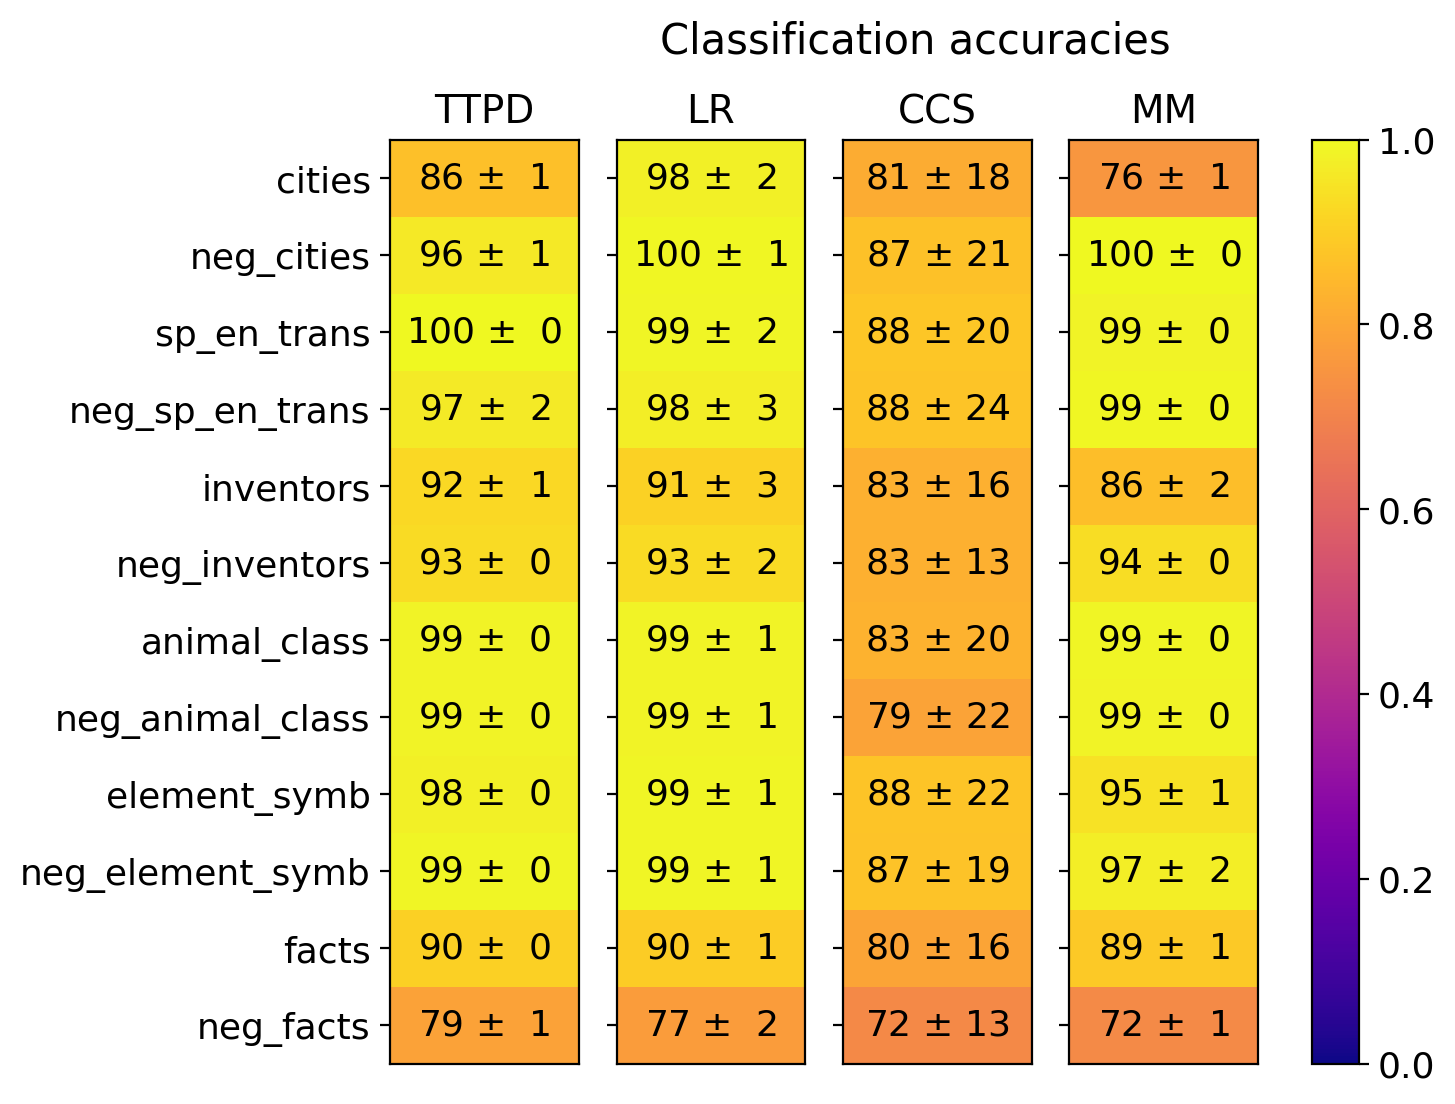

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(7, 6), ncols=4)
titles = ["TTPD", "LR", "CCS", "MM"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4), (TTPD, LRProbe, CCSProbe, MMProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in train_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in train_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(train_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(train_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)

plt.savefig(f"./results/lie_detection--unseen_topics--{model_name}.svg", 
            bbox_inches = "tight")

### Generalization to logical conjunctions and disjunctions

In [7]:
# compare TTPD, LR, CCS and MM on logical conjunctions and disjunctions
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj",
            "common_claim_true_false", "counterfact_true_false"]


probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list), MMProbe: defaultdict(list)}
num_iter = 20

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                             model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

Training and evaluating classifiers: 100%|██████████| 80/80 [02:33<00:00,  1.91s/it]


In [8]:
show_and_save_results(probe_accuracies, stat_results, "logical_junctions")

TTPD:
  Mean Accuracy: 75.45%
  Standard Deviation of the mean accuracy: 0.33%
LRProbe:
  Mean Accuracy: 70.78%
  Standard Deviation of the mean accuracy: 2.38%
CCSProbe:
  Mean Accuracy: 70.73%
  Standard Deviation of the mean accuracy: 7.27%
MMProbe:
  Mean Accuracy: 74.28%
  Standard Deviation of the mean accuracy: 0.54%


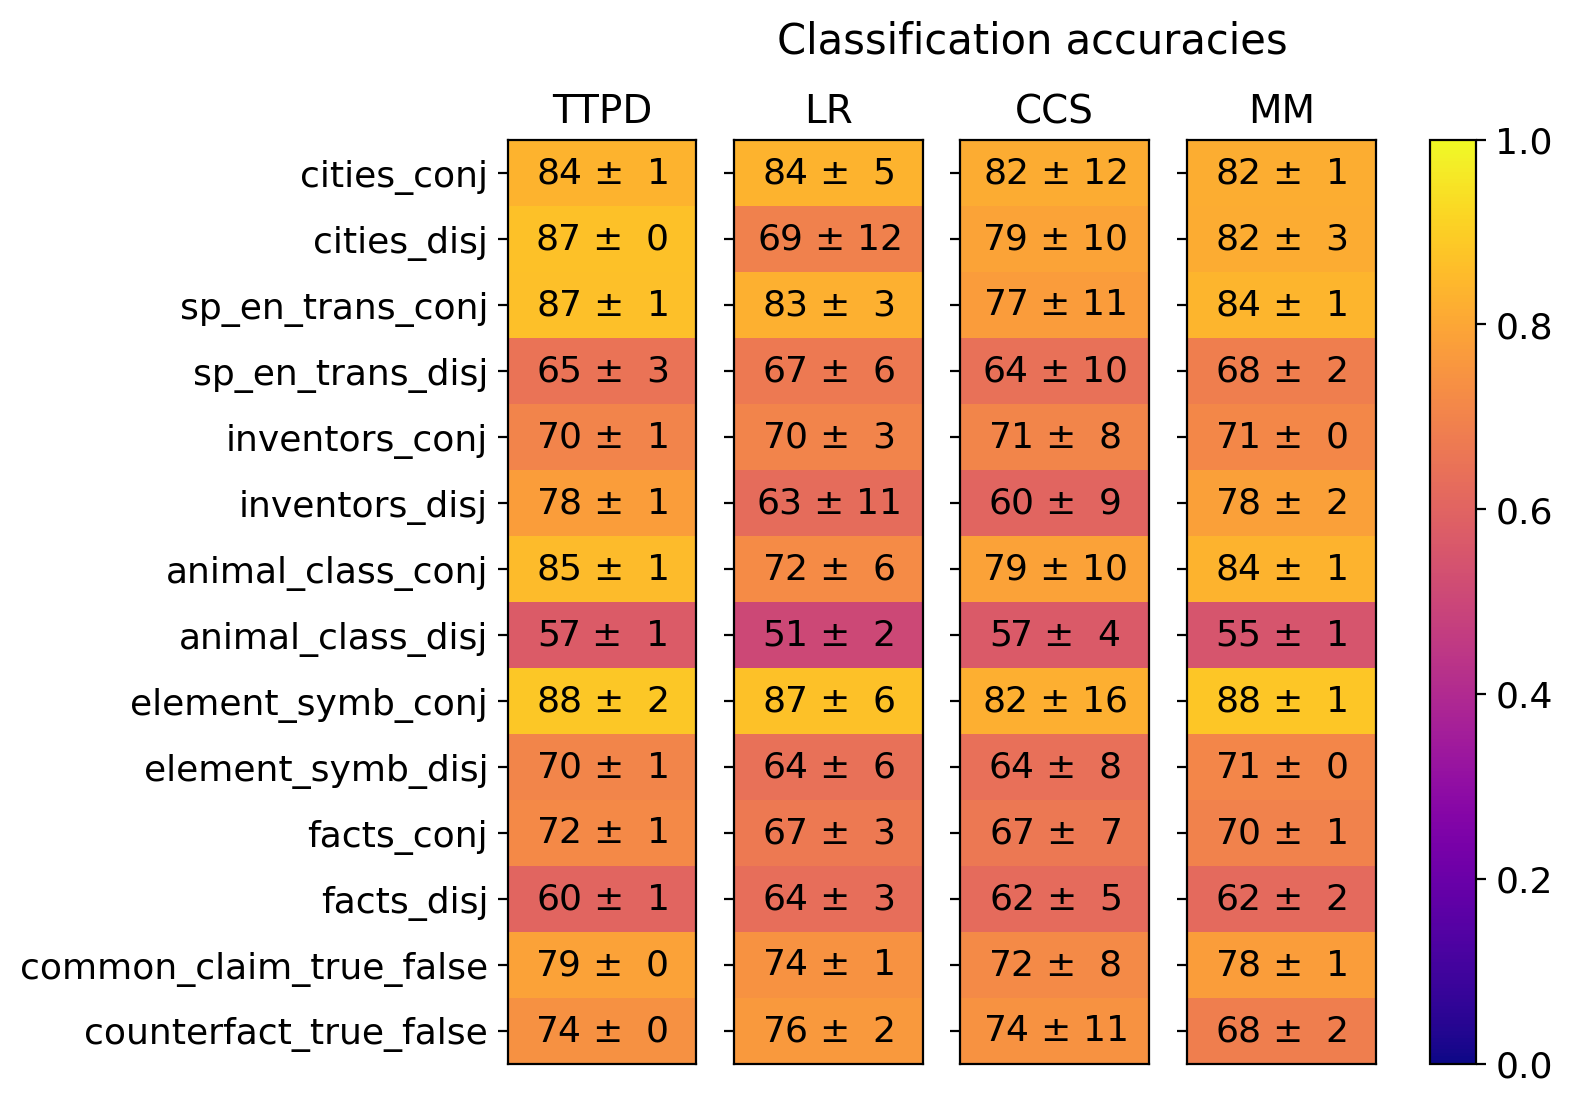

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(7, 6), ncols=4)
titles = ["TTPD", "LR", "CCS", "MM"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4), (TTPD, LRProbe, CCSProbe, MMProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(val_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)

plt.savefig(f"./results/lie_detection--logical_junctions--{model_name}.svg", 
            bbox_inches = "tight")

### Generalization to German statements

In [10]:
# compare TTPD, LR, CCS and MM on statements translated to german
val_sets = ["cities_de", "neg_cities_de", "sp_en_trans_de", "neg_sp_en_trans_de", "inventors_de", "neg_inventors_de", "animal_class_de",
                  "neg_animal_class_de", "element_symb_de", "neg_element_symb_de", "facts_de", "neg_facts_de"]


probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list), MMProbe: defaultdict(list)}
num_iter = 20

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                                           model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

Training and evaluating classifiers: 100%|██████████| 80/80 [01:46<00:00,  1.33s/it]


In [11]:
show_and_save_results(probe_accuracies, stat_results, "german")

TTPD:
  Mean Accuracy: 87.36%
  Standard Deviation of the mean accuracy: 0.37%
LRProbe:
  Mean Accuracy: 89.12%
  Standard Deviation of the mean accuracy: 1.39%
CCSProbe:
  Mean Accuracy: 77.26%
  Standard Deviation of the mean accuracy: 17.12%
MMProbe:
  Mean Accuracy: 83.15%
  Standard Deviation of the mean accuracy: 1.51%


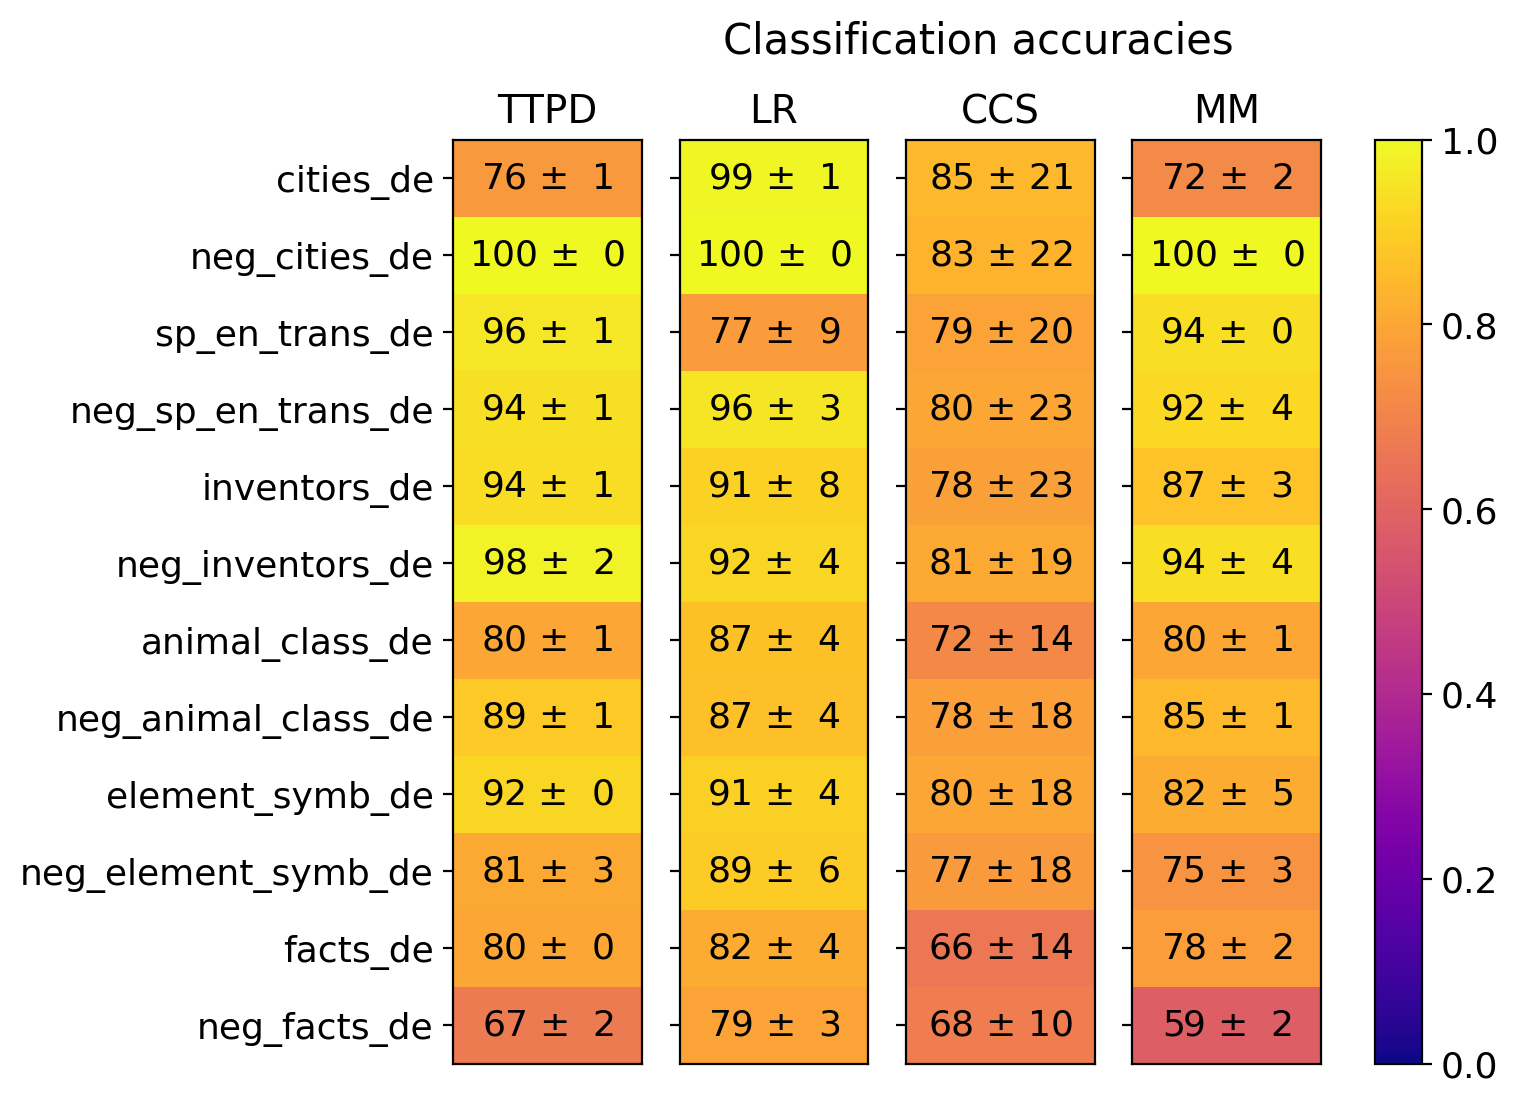

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(7, 6), ncols=4)
titles = ["TTPD", "LR", "CCS", "MM"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4), (TTPD, LRProbe, CCSProbe, MMProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(val_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)

plt.savefig(f"./results/lie_detection--german--{model_name}.svg", 
            bbox_inches = "tight")

### Displaying generalization to Conjunctions, Disjunctions and German statements in one table

In [9]:
# Define the validation sets and the probe types
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj", "cities_de", "neg_cities_de", "sp_en_trans_de", "neg_sp_en_trans_de", "inventors_de", "neg_inventors_de", "animal_class_de",
                  "neg_animal_class_de", "element_symb_de", "neg_element_symb_de", "facts_de", "neg_facts_de",
            "common_claim_true_false", "counterfact_true_false"]

probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list), MMProbe: defaultdict(list)}
num_iter = 20

# Training and evaluating classifiers
total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar:
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                                           model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers: 100%|██████████| 80/80 [03:25<00:00,  2.57s/it]


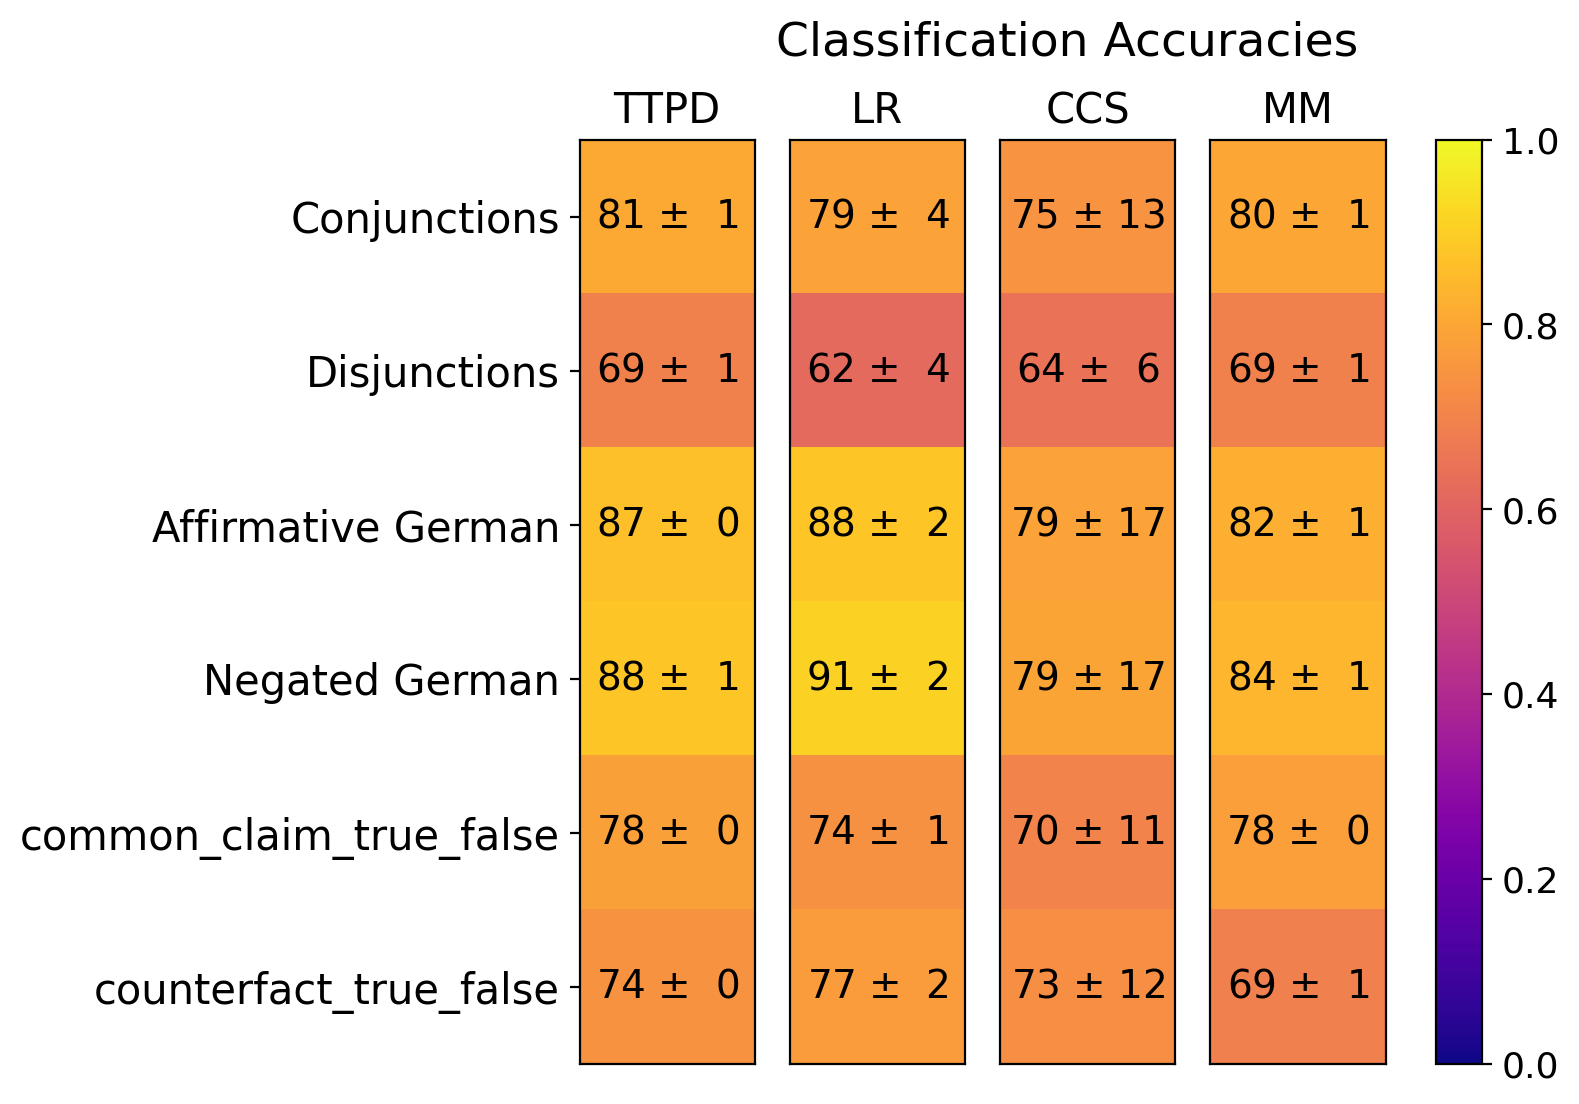

In [10]:
# Define the groups
groups = {
    'Conjunctions': [dataset for dataset in val_sets if dataset.endswith('_conj')],
    'Disjunctions': [dataset for dataset in val_sets if dataset.endswith('_disj')],
    'Affirmative German': [dataset for dataset in val_sets if dataset.endswith('_de') and not dataset.startswith('neg_')],
    'Negated German': [dataset for dataset in val_sets if dataset.startswith('neg_') and dataset.endswith('_de')],
    'common_claim_true_false': ['common_claim_true_false'],
    'counterfact_true_false': ['counterfact_true_false']
}

# Initialize group results
group_results = {probe_type: {group_name: [] for group_name in groups} for probe_type in probe_types}

# Process results to compute mean accuracies per group per classifier
for probe_type in probe_types:
    for n in range(num_iter):
        for group_name, group_datasets in groups.items():
            accuracies = []
            for dataset in group_datasets:
                accuracy = results[probe_type][dataset][n]
                accuracies.append(accuracy)
            mean_accuracy = sum(accuracies) / len(accuracies)
            group_results[probe_type][group_name].append(mean_accuracy)

# Compute statistics
stat_group_results = {probe_type: {'mean': {}, 'std': {}} for probe_type in probe_types}

for probe_type in probe_types:
    for group_name in groups:
        accuracies = group_results[probe_type][group_name]
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        stat_group_results[probe_type]['mean'][group_name] = mean_accuracy
        stat_group_results[probe_type]['std'][group_name] = std_accuracy

# Map probe types to classifier names
probe_type_to_name = {
    TTPD: 'TTPD',
    LRProbe: 'LR',
    CCSProbe: 'CCS',
    MMProbe: 'MM'
}

# Create DataFrames for mean accuracies and standard deviations
group_names = ['Conjunctions', 'Disjunctions', 'Affirmative German', 'Negated German', 'common_claim_true_false', 'counterfact_true_false']
classifier_names = ['TTPD', 'LR', 'CCS', 'MM']

mean_df = pd.DataFrame(index=group_names, columns=classifier_names)
std_df = pd.DataFrame(index=group_names, columns=classifier_names)

for probe_type in probe_types:
    classifier_name = probe_type_to_name[probe_type]
    for group_name in group_names:
        mean_accuracy = stat_group_results[probe_type]['mean'][group_name]
        std_accuracy = stat_group_results[probe_type]['std'][group_name]
        mean_df.loc[group_name, classifier_name] = mean_accuracy
        std_df.loc[group_name, classifier_name] = std_accuracy

fig, axes = plt.subplots(figsize=(6.5, 6), ncols=4)

for idx, classifier_name in enumerate(classifier_names):
    ax = axes[idx]
    mean_values = mean_df[classifier_name].values.astype(float)
    std_values = std_df[classifier_name].values.astype(float)
    
    # Create heatmap
    im = ax.imshow(mean_values[:, np.newaxis], vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # Annotate the heatmap with mean accuracies and standard deviations
    for i in range(len(group_names)):
        mean_accuracy = mean_values[i]
        std_accuracy = std_values[i]
        ax.text(0, i, f'{round(mean_accuracy * 100):2d} $\pm$ {round(std_accuracy * 100):2d}', ha='center', va='center', fontsize=14)
    
    # Set ticks and labels
    ax.set_xticks([])
    if idx == 0:
        ax.set_yticks(np.arange(len(group_names)))
        ax.set_yticklabels(group_names, fontsize=15)
    else:
        ax.set_yticks([])
    ax.set_title(classifier_name, fontsize=15)

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification Accuracies", fontsize=17)

plt.savefig(f"./results/lie_detection--overall_generalization--{model_name}.svg", 
            bbox_inches = "tight")

### Real world scenarios / lies

In [14]:
probe_types = [TTPD, LRProbe, CCSProbe, MMProbe]
results = {TTPD: [], LRProbe: [], CCSProbe: [], MMProbe: []}
num_iter = 50

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family,
                                                                                           model_size, model_type,layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)

            # evaluate classification accuracy on real world scenarios
            dm = DataManager()
            real_world_dataset = "real_world_scenarios/all_unambiguous_replies"
            dm.add_dataset(real_world_dataset, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
            acts, labels = dm.data[real_world_dataset]
            
            # classifier specific predictions
            if probe_type == CCSProbe:
                acts = acts - (mean_affirm + mean_neg)/2

            predictions = probe.pred(acts)
            results[probe_type].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


In [15]:
# Show and save classifier accuracies
result_lines = []
for probe_type in probe_types:
    mean = np.mean(results[probe_type])
    std = np.std(results[probe_type])
    result_lines.append(f"{probe_type.__name__}:")
    result_lines.append(f"  Mean Accuracy: {mean*100:.2f}%")
    result_lines.append(f"  Standard Deviation: {std*100:.2f}%")
result_str = "\n".join(result_lines)

print(result_str)
with open(f"./results/lie_detection--real_world_lies--{model_name}.txt", "w") as f:
    f.write(result_str)

TTPD:
  Mean Accuracy: 93.77%
  Standard Deviation: 1.65%
LRProbe:
  Mean Accuracy: 77.63%
  Standard Deviation: 8.26%
CCSProbe:
  Mean Accuracy: 74.12%
  Standard Deviation: 13.00%
MMProbe:
  Mean Accuracy: 90.69%
  Standard Deviation: 1.16%
